# Decision Tree Implementation

### The Project is Divided into 4 parts :
- Loading and Cleaning Data Set
- Printing Decision Tree Steps
- Recreating the Actual Decision Tree
-  Visualizing Decision Tree from graph_viz using the inbuilt Classifier

### Note : 
- Expanation for some parts are given at the start of that part

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix
import math
from sklearn.model_selection import train_test_split

### 1. Loading and Cleaning Dataset

### Explanantion
1. This part deals with cleaning the dataset and changing continuous values to discrete values. Since Decision Tree works best on categorical data
2. To do so, there are 2 functions created :
- get_range_dict()
    - This function create class intervals among the continuous values and group them accordingly. 
    For example, given 'Age' column with values - 23, 45, 56, 1, 2
    It will create a dictionary such as {group 1 : [0 - 5], group 2 : [5 - 10]}
- continous_to_discrete()
    - This function uses the dictionary returned by the previous function and traverse all continuous values of the column and change to the group according to the range.
    
- Formula used to make k groups :
    - group_size = (max_value - min_value) / number_of_groups_to_be_made
    - kth_group_range = (min_val + (k - 1) * group_size, min_val + (k) * group_size)

#### Loading Data

In [2]:
## loading dataset
iris = datasets.load_iris()
iris_x = iris.data
iris_y = iris.target
iris = pd.DataFrame(iris_x, columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
## merging output column in the dataframe
iris['Y'] = iris_y

In [3]:
iris

,sepal_length,sepal_width,petal_length,petal_width,Y
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


#### Changing Continuous Values to Discrete Values

In [4]:
def get_range_dict(feature, bins) :
    
    ## bins = number of groups to be made
    group_size = ((feature.max() - feature.min()) / bins)
    ## this dictionary will contain group_number as keys and min_max range as value
    class_intervals = dict()
    ## using the formula to make ranges
    for group_number in range(1, bins + 1) :
        
        range_min = feature.min() + ((group_number - 1) * group_size)
        range_max = feature.min() + ((group_number) * group_size)
        
        class_intervals[group_number] = (range_min, range_max)
    
    return class_intervals

In [5]:
def continous_to_discrete(feature, class_intervals) :
    ## creating new column list
    new_group = list()
    
    ## traversing the column values
    for feature_value in feature :
        ## special case for the max value as range = [a, b) b not included, this means that max value won't be included
        ## so putting max value in the last group
        if feature_value == feature.max() : 
            new_group.append(len(class_intervals))    
        
        else :
            for group in class_intervals :
                mini = class_intervals[group][0]
                maxi = class_intervals[group][1]

                if ((feature_value >= mini) and (feature_value < maxi)) :

                    new_group.append(group)
                    break
                
    return new_group

In [6]:
## dataframe has output column as well, so excluding the output column as its position is -1
features = iris.columns[: -1]
## traversing all columns
for feature in features :
    ## defining k (number of groups to be made)
    k = 5
    class_intervals = get_range_dict(iris[feature], k)
    iris[feature] = continous_to_discrete(iris[feature], class_intervals)

In [7]:
## new iris dataframe
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,Y
0,2,4,1,1,0
1,1,3,1,1,0
2,1,3,1,1,0
3,1,3,1,1,0
4,1,4,1,1,0


### 2. Printing Decision Tree Steps

In [8]:
## the main function
## this is a recursive function
def print_decision_tree(iris, features, level) :
    print('Level', level)
    ## printing the state of current node output set, val : val_count
    print_output_set(iris)
    ## calculating entropy for current node
    current_entropy = calculate_entropy(iris)
    print('Current Entropy is =', current_entropy)
    
    ## base case
    ## There are 2 base cases
    
    ## If the current node is leaf node
    
    if len(features) == 0 :
        print('Reached leaf Node')
        return
    
    ## pure output
    ## checking if the node is pure, that is, if the output set just has 1 value
    pure = check_pure(iris)
    if pure :
        print('Reached leaf Node')
        return
    
    ## since the node is neither leaf or pure, we will split the tree in this case with best feature possible
    ## To get the best accuracy score we will split the tree here, by selecting the best feature
    ## Calculating the best feature -> finding the feature which has the max gain ratio
    
    ## Traversing all features and calculating gain ratios for each ratio and getting the max best
    
    max_gain_ratio = -math.inf
    max_feature = None
    
    for feature in features :
        
        ## calling function for calculating gain ratio
        gain_ratio = calculate_gain_ratio(iris, feature)
        
        if gain_ratio > max_gain_ratio :
            max_gain_ratio = gain_ratio
            max_feature = feature
    
    print('Splitting on feature', max_feature, 'with gain ratio', max_gain_ratio)
    
    ## Since this is a recursive function, we are following a 'top-down' approach, for each new recursive call we will
    ## provide new feature column
    
    ## creating new features list
    ## this won't be having the current selected feature for the new recursive calls
    new_features = []
    
    for feature in features :
        
        if feature != max_feature :
            new_features.append(feature)
    
    ## recursive call on each category of the best feature column
    unique_feature_val = list(set(iris[max_feature]))
    
    for feature_val in unique_feature_val :
        sub_iris = iris[iris[max_feature] == feature_val]
        print()
        ## recurive call
        print_decision_tree(sub_iris, new_features, level + 1)

In [9]:
## This function prints the state of current node output set. val : count of values
def print_output_set(iris) :
    
    ## creating a dictionary
    val_count = iris.Y.value_counts().to_dict()
    myKeys = list(val_count.keys())
    ## sorting the dictionaries by keys
    myKeys.sort()
    sorted_dict = {i: val_count[i] for i in myKeys}
    
    ## printing state
    for key in sorted_dict :
        print('Count of', key, 'is =', sorted_dict[key])

In [10]:
def calculate_entropy(iris) :
    
    ## entropy formula for a current node = -sum(pi * log(pi)), where pi = count of a particular value / total count
    ## creating dictionary
    val_count = iris.Y.value_counts().to_dict()
    entropy = 0
    ## traversing the dictionary and subtracting all entropies
    for val in val_count :
        sub_df = iris[iris.Y == val]
        expression = len(sub_df) / len(iris)
        proba = expression * math.log(expression, 2)
        entropy -= proba
    
    return entropy

In [11]:
## returns true if output set is unique
def check_pure(iris) :
    ## creating value count dictionary
    val_count = iris.Y.value_counts().to_dict()
    ## if length of dictionary is 1, that is, there is only one value in output set
    if len(val_count) == 1 :
        return True
    else :
        return False

In [12]:
## gain_ratio = information_gain / split_info
def calculate_gain_ratio(iris, feature) :
    
    ### calculating information_gain first
    ### total information gain = (parent_entropy) - (sum of weighted average of child entropies)
    
    ## getting base or parent entropy
    main_entropy = calculate_entropy(iris)
    
    ## creating dictionary of this feature
    val_count = iris[feature].value_counts().to_dict()
    
    total = 0
    for key in val_count :
        ## getting entropy for each children
        sub_entropy = calculate_entropy(iris[iris[feature] == key])
        ## adding the weighted average
        total += (len(iris[iris[feature] == key]) / len(iris)) * sub_entropy
    
    total_entropy = (main_entropy - total)
    
    ### calculating split_info
    
    val_count = iris[feature].value_counts().to_dict()
    
    ## split_info = -sum((|Di| / |D|) * log((|Di| / |D|)))
    ## Di count of ith child
    ## D is the total count
    split_info = 0
    for key in val_count :

        proba = (len(iris[iris[feature] == key]) / len(iris))
        ans =  (proba * math.log(proba, 2))
        split_info -= ans
    
    
    if split_info == 0 :
        return 0
    gain_ratio = total_entropy / split_info
    
    return gain_ratio

In [13]:
## calling the function
features = iris.columns[: -1]
print_decision_tree(iris, features, 0)

Level 0
Count of 0 is = 50
Count of 1 is = 50
Count of 2 is = 50
Current Entropy is = 1.584962500721156
Splitting on feature petal_length with gain ratio 0.6345315547087994

Level 1
Count of 0 is = 50
Current Entropy is = 0.0
Reached leaf Node

Level 1
Count of 1 is = 3
Current Entropy is = 0.0
Reached leaf Node

Level 1
Count of 1 is = 33
Count of 2 is = 1
Current Entropy is = 0.19143325481419346
Splitting on feature petal_width with gain ratio 0.14552679703433025

Level 2
Count of 1 is = 5
Current Entropy is = 0.0
Reached leaf Node

Level 2
Count of 1 is = 27
Current Entropy is = 0.0
Reached leaf Node

Level 2
Count of 1 is = 1
Count of 2 is = 1
Current Entropy is = 1.0
Splitting on feature sepal_length with gain ratio 1.0

Level 3
Count of 2 is = 1
Current Entropy is = 0.0
Reached leaf Node

Level 3
Count of 1 is = 1
Current Entropy is = 0.0
Reached leaf Node

Level 1
Count of 1 is = 14
Count of 2 is = 33
Current Entropy is = 0.8786744932173093
Splitting on feature petal_width with 

### 3. Recreating the Actual Decision Tree Class

In [14]:
## tree node class
## it stores feature as the next_pointer, and category as the cuurent category
class DecisionTreeNode :
    
    def __init__(self, category = None, feature = None, y_output = None) :
        
        self.category = category
        self.feature = feature
        self.y_output = y_output
        self.children = list()

In [15]:
class DecisionTreeClassifierRemake :
    
    def __init__(self) :
        ## creates a tree node to store the complete tree in this class
        self.TreeRoot = None
        pass
    
    def get_majority_Y(self, iris) :
        ## returns the count of child with max count
        return list(iris.Y.value_counts().to_dict().keys())[0]
    
    def build_decision_tree(self, iris, features, category) :
        ## this function will create the decision tree itself
        ## For a node this function stores, the category will sotre the previous feature category and 
        ## feature will store the category to split the tree
        
        ## base case : explained in previous part as well
        if len(features) == 0 :
            y_output = self.get_majority_Y(iris)
            ## creating leaf node, and storing the majority output for the path.
            node = DecisionTreeNode(category = category, feature = None, y_output = y_output)
            return node
        pure = check_pure(iris)
        if pure :
            y_output = self.get_majority_Y(iris)
            ## creating leaf node, and storing the majority output for the path.
            node = DecisionTreeNode(category = category, feature = None, y_output = y_output)
            return node

        ## decide feature : already explained in previous part
        max_gain_ratio = -math.inf
        max_feature = None
        for feature in features :

            gain_ratio = calculate_gain_ratio(iris, feature)

            if gain_ratio > max_gain_ratio :
                max_gain_ratio = gain_ratio
                max_feature = feature
        
        ## creating root, (the root node, 1st node will dont have any category as we have not split anything yet)
        ## and y_output for that path is not ye decided.
        root = DecisionTreeNode(category = category, feature = max_feature, y_output = None)

        new_features = []
        for feature in features :

            if feature != max_feature :
                new_features.append(feature)

        unique_feature_val = list(set(iris[max_feature]))
        for feature_val in unique_feature_val :

            sub_iris = iris[iris[max_feature] == feature_val]
            ## in the recursion call we are providing new category to store.
            child = self.build_decision_tree(sub_iris, new_features, feature_val)
            root.children.append(child)

        return root
    
    def fit(self, iris) :
        ## this function is actually called by main function
        ## it calls the build_tree function and created the tree
        features = iris.columns[: -1]
        self.TreeRoot = self.build_decision_tree(iris, features, None)
    
    def print_decision_tree(self) :
        ## this function calls the print_tree_function
        if not self.TreeRoot :
            print('Model no trained yet!!!')
            return
            
        self.print_tree(self.TreeRoot, 0)
    
    def print_tree(self, root, level) :
        ## this function will print the decision tree in pre order fashion
        
        ## base case
        ## using 'Feature' as null ptr, as at leaf there is no feature to further split the tree.
        print('Level =',level, end = ', ')
        if not root.feature :
            print('Category =',root.category, ', leaf')
            return

        print('Category =', root.category, ', Next Feature to split =',root.feature)
        for child in root.children :
            self.print_tree(child, level + 1)
    
    
    def predict(self, x_test) :
        ## this function is called by main. and it calls the actual predict function defined below
        if not self.TreeRoot :
            print('Model no trained yet!!!')
            return 
        
        y_pred = self.predict_output(x_test, self.TreeRoot)
        return y_pred
    
    def predict_output(self, x_test, tree) :
        ## traverse each input, for each input path it will predict the y_output
        y_pred = list()
        input_x = x_test.values
        for x in input_x :
            ans = self.get_y_pred(tree, x)
            y_pred.append(ans)
        return y_pred
    
    def get_y_pred(self, tree, x) :
        ## base case
        ## using 'feature' as null ptr base condition
        if not tree.feature :
            return tree.y_output
        ## select the feature and check category of next
        index = {'sepal_length' : 0, 'sepal_width' : 1, 'petal_length' : 2, 'petal_width' : 3}
        next_feature = tree.feature
        feature_index = index[next_feature]
        category_to_visit = x[feature_index]
        
        ## since we have the input only and not the lables, the recursion call is on any best feature and not in 0 1 2 index
        ## order, that is why we will map the labels (which are actually stored in 'Feature')
        ## and select the feature from the input, by the index

        for child in tree.children :
            ## we will only go to one path, 
            ## only to one selected category
            ## we need the answer of one path, not all paths.
            ## we will match the input category to one of the paths in the split and move on
            if child.category == category_to_visit :
                ## returns the output
                return self.get_y_pred(child, x)

#### Splitting Data for Train and Test

In [16]:
df = iris.copy()
iris_y = df.Y
del df['Y']
iris_x = df
x_train, x_test, y_train, y_test = train_test_split(iris_x, iris_y, random_state = 42)
## merging output column in x_train
x_train['Y'] = y_train

#### Creating Object of Self made Decision Tree 

In [17]:
self_decision_tree_object = DecisionTreeClassifierRemake()

#### Training

In [18]:
## note the x_train has y_output column merged above
self_decision_tree_object.fit(x_train)

####  Printing the Tree

In [19]:
## calling print method
self_decision_tree_object.print_decision_tree()

Level = 0, Category = None , Next Feature to split = petal_length
Level = 1, Category = 1 , leaf
Level = 1, Category = 2 , leaf
Level = 1, Category = 3 , Next Feature to split = petal_width
Level = 2, Category = 2 , leaf
Level = 2, Category = 3 , leaf
Level = 2, Category = 4 , Next Feature to split = sepal_length
Level = 3, Category = 1 , leaf
Level = 3, Category = 3 , leaf
Level = 1, Category = 4 , Next Feature to split = petal_width
Level = 2, Category = 3 , Next Feature to split = sepal_length
Level = 3, Category = 3 , Next Feature to split = sepal_width
Level = 4, Category = 1 , leaf
Level = 4, Category = 2 , leaf
Level = 4, Category = 3 , leaf
Level = 3, Category = 4 , leaf
Level = 2, Category = 4 , Next Feature to split = sepal_length
Level = 3, Category = 2 , leaf
Level = 3, Category = 3 , Next Feature to split = sepal_width
Level = 4, Category = 2 , leaf
Level = 4, Category = 3 , leaf
Level = 3, Category = 4 , Next Feature to split = sepal_width
Level = 4, Category = 3 , leaf
L

#### Testing

In [20]:
## predicting the output
y_pred = self_decision_tree_object.predict(x_test)

#### Comparing Predicted Output and Actual Output

In [21]:
print('Total Test Data Points =', len(y_pred))
print()
success_count = 0
fail_count = 0
for i in range(len(y_pred)) :
    print('Actual :',list(y_test)[i], 'Predicted :',y_pred[i])
    if y_pred[i] == list(y_test)[i] :
        success_count += 1
    else :
        fail_count += 1

Total Test Data Points = 38

Actual : 1 Predicted : 2
Actual : 0 Predicted : 0
Actual : 2 Predicted : 2
Actual : 1 Predicted : 1
Actual : 1 Predicted : 1
Actual : 0 Predicted : 0
Actual : 1 Predicted : 1
Actual : 2 Predicted : 2
Actual : 1 Predicted : 1
Actual : 1 Predicted : 1
Actual : 2 Predicted : 2
Actual : 0 Predicted : 0
Actual : 0 Predicted : 0
Actual : 0 Predicted : 0
Actual : 0 Predicted : 0
Actual : 1 Predicted : 2
Actual : 2 Predicted : 2
Actual : 1 Predicted : 1
Actual : 1 Predicted : 1
Actual : 2 Predicted : 2
Actual : 0 Predicted : 0
Actual : 2 Predicted : 2
Actual : 0 Predicted : 0
Actual : 2 Predicted : 2
Actual : 2 Predicted : 2
Actual : 2 Predicted : 2
Actual : 2 Predicted : 2
Actual : 2 Predicted : 2
Actual : 0 Predicted : 0
Actual : 0 Predicted : 0
Actual : 0 Predicted : 0
Actual : 0 Predicted : 0
Actual : 1 Predicted : 1
Actual : 0 Predicted : 0
Actual : 0 Predicted : 0
Actual : 2 Predicted : 2
Actual : 1 Predicted : 1
Actual : 0 Predicted : 0


In [22]:
success = (success_count / len(y_pred))
fail = (fail_count / len(y_pred))
print('Success Rate :', success)
print('Failure Rate :', fail)

Success Rate : 0.9473684210526315
Failure Rate : 0.05263157894736842


#### Conclusion
The Recreated model is working great on this test data with success rate : 94.7%

### 4. Visualizing Decision Tree from graph_viz using the inbuilt Classifier
- Note : We will use the inbuilt classifier here

#### Iris

In [23]:
## loading dataset
iris = datasets.load_iris()
iris_x = iris.data
iris_y = iris.target
iris_df = pd.DataFrame(iris_x, columns = ['sl', 'sw', 'pl', 'pw'])
iris_df

,sl,sw,pl,pw
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [24]:
## using the inbuilt Decision Tree Classifier here
DecisionTree_object = DecisionTreeClassifier()
DecisionTree_object.fit(iris_x, iris_y)

DecisionTreeClassifier()

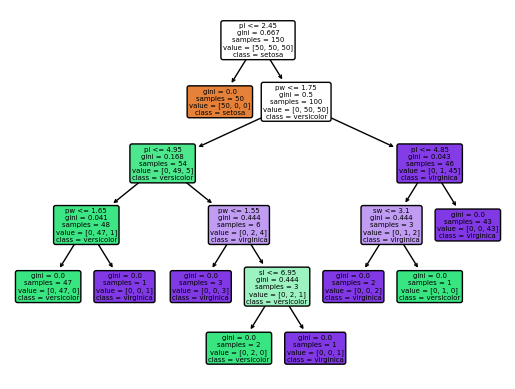

<Figure size 2000x1500 with 0 Axes>

In [25]:
## using plot_tree funciton
plot_tree(DecisionTree_object, fontsize = 5, filled = True, feature_names = ['sl', 'sw', 'pl', 'pw'], 
         class_names = iris.target_names, rounded = True)
plt.figure('Iris Tree', figsize = [20, 15])
plt.show()

#### OR table

In [26]:
OR_table = [[0, 1, 0, 1], [0, 0, 1, 1], [0, 0, 0, 1]]
OR_table = pd.DataFrame(np.transpose(np.array(OR_table)), columns = ['X1', 'X2', 'Y'])
OR_df = OR_table.copy()
OR_y = OR_df['Y']
del OR_df['Y']
OR_x = OR_df
OR_table

,X1,X2,Y
0,0,0,0
1,1,0,0
2,0,1,0
3,1,1,1


In [27]:
DecisionTree_object = DecisionTreeClassifier()
DecisionTree_object.fit(OR_x, OR_y)

DecisionTreeClassifier()

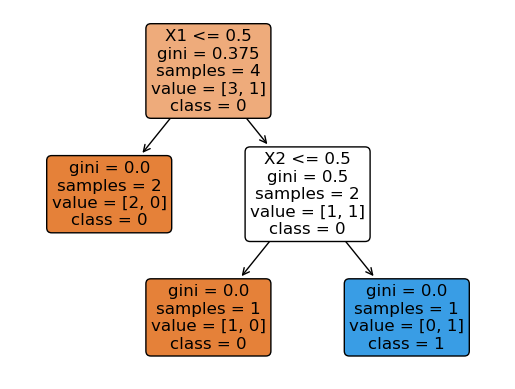

<Figure size 2000x1500 with 0 Axes>

In [28]:
plot_tree(DecisionTree_object, fontsize = 12, filled = True, feature_names = ['X1', 'X2'], 
         class_names = ['0', '1'], rounded = True)
plt.figure('OR table Tree', figsize = [20, 15])
plt.show()

### BY - PRATEEK SARNA